In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#loading the stopwords library and the nltk to be used for the text preprocessing
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eosamau/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eosamau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t')
train_data.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
train_data['condition'].value_counts()

condition
Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Dissociative Identity Disorde                                  1
Hydrocephalus                                                  1
Hyperlipoproteinemia Type III, Elevated beta-VLDL   IDL        1
Q Feve                                                         1
Neutropenia                                                    1
Name: count, Length: 884, dtype: int64

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re



def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    return ' '.join(tokens) #--- Joins the token into a simple word. 

train_data['processed_review'] = train_data['review'].apply(preprocess_text)
test_data['processed_review'] = test_data['review'].apply(preprocess_text)
train_data['processed_review'].head()

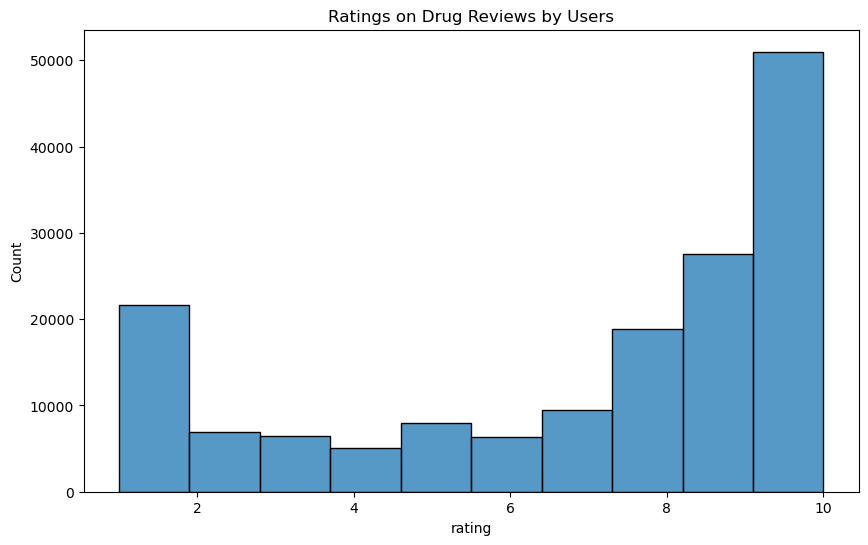

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(train_data['rating'], bins=10)
plt.title('Ratings on Drug Reviews by Users')
plt.savefig('histogram_of_ratings.png')
plt.show()

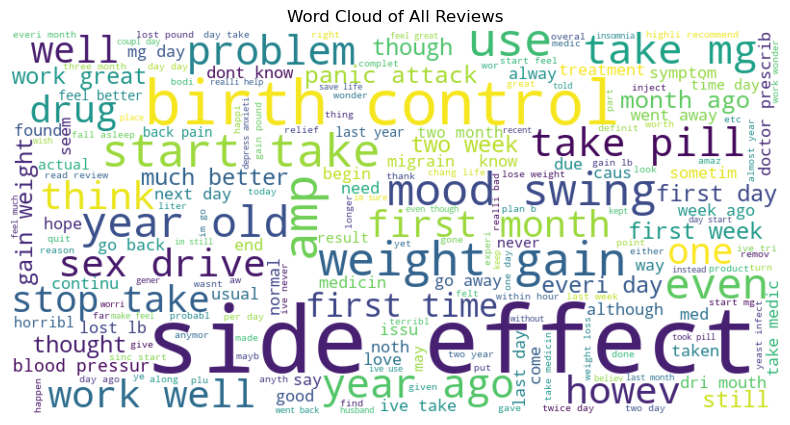

In [17]:
#creating a word cloud to visualize the most used words in 215,063 drug reviews by the users
from wordcloud import WordCloud

all_words = ' '.join(train_data['processed_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')

plt.title('Word Cloud of All Reviews')

plt.savefig('wordcloud.png')
plt.show()

In [18]:
#---------TF-IDF -----------#

#Now in this stage we want to assign importance to words in the training data by using the TF IDF method which 
#can help distinguish words in accordance to how they are most used for ratings

#tfidf = TfidfVectorizer(max_features=5000)
#X_tfidf = tfidf.fit_transform(train_data['processed_review'])
#y = train_data['rating']
#X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)



## Text Processing and Feature Engineering

In [19]:
import gensim

# Training a Word2Vec model tokenized reviews using the SkipGram method
word2vec_model = gensim.models.Word2Vec(sentences=train_data['processed_review'], vector_size=300, window=5, min_count=2, sg=1, workers=4)


def get_average_word2vec(tokens_list, model, vector_size):
    
    valid_words = [word for word in tokens_list if word in model.wv.key_to_index] #vocabulary from word2Vec model
    
    if not valid_words: 
        return np.zeros(vector_size) #we want to return a zero vector for the doc in case no valid words are found in the doc
    
    return np.mean(model.wv[valid_words], axis=0) # the entire review is converted into a single vector, 
                                                  #instead of different vectors for each word in the document

vector_size = word2vec_model.vector_size
train_data['word2vec_review'] = train_data['processed_review'].apply(lambda x: get_average_word2vec(x, word2vec_model, vector_size))


X_word2vec = np.vstack(train_data['word2vec_review'].values) # To convert the into a numpy array


In [53]:
def categorize_sentiment(rating):
    if rating <= 4:
        return 0  # Negative
    elif rating <= 7:
        return 1  # Neutral
    else:
        return 2  # Positive
    
train_data['sentiment'] = train_data['rating'].apply(categorize_sentiment)
y = train_data['sentiment']

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Training and Evaluation

In [70]:
X_train_scaled.shape

(129037, 300)

#### Randomly reducing the principal components to 10 and evaluating the XGBoost Model

In [1]:

from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


xgb_classifier = XGBClassifier(n_estimators=100, max_depth = 5, 
                               learning_rate=0.1, random_state = 42, n_jobs=-1)  
xgb_classifier.fit(X_train_scaled, y_train)
xgb_pred = xgb_classifier.predict(X_test_scaled)

print("\XGBoost Classifier Results:")
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive']))

NameError: name 'X_train_scaled' is not defined

In [96]:
rf_classifier = RandomForestClassifier(n_estimators=200, max_depth=10,
                                           n_jobs=-1, random_state=42)
rf_classifier.fit(X_train_reduced, y_train)
rf_pred = rf_classifier.predict(X_test_reduced)

print("\nRandom Forest Classifier Results:")
print(classification_report(y_test, rf_pred, target_names=['Negative', 'Neutral', 'Positive']))


Random Forest Classifier Results:
              precision    recall  f1-score   support

    Negative       0.21      0.00      0.00      7961
     Neutral       0.00      0.00      0.00      4899
    Positive       0.60      1.00      0.75     19400

    accuracy                           0.60     32260
   macro avg       0.27      0.33      0.25     32260
weighted avg       0.41      0.60      0.45     32260



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Checking for the optimal PCA features that has high explained variance

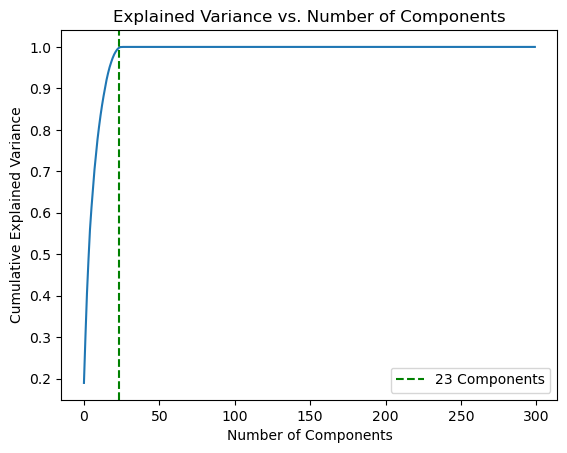

<Figure size 640x480 with 0 Axes>

In [93]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on scaled data
pca = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

num_components_99 = np.argmax(cumulative_variance >= 0.99) + 1
# Add a vertical line at the point where it explains 95% variance
plt.axvline(x=num_components_99, color='g', linestyle='--', label=f'{num_components_99} Components')
# Annotate the plot to show where the peak occurs
#plt.text(num_components_99, cumulative_variance[num_components_99 - 1], f'{num_components_99} components', 
        # horizontalalignment='right', verticalalignment='bottom')

plt.legend()
plt.show()
plt.savefig('PCA feature selection.png')

# Choose components to retain 95% of variance
pca = PCA(n_components=0.99)  # Retains components that explain 95% of variance
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.fit_transform(X_test_scaled)


## Using the Genetic Algorithm for Hyper parameter tuning

#### Using GridSearchCV for Hyper Parameters


### Dealing with the class imbalances

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_reduced, y_train)

best_xgb.fit(X_train_balanced, y_train_balanced)

### Feature Selection

In [ ]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(best_xgb, prefit=True)
X_train_selected = selector.transform(X_train_balanced)
X_test_selected = selector.transform(X_test_reduced)

best_xgb.fit(X_train_selected, y_train_balanced)

### Other Algorithms

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_selected, y_train_balanced)

voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb), ('rf', rf)],
    voting='soft'
)
voting_clf.fit(X_train_selected, y_train_balanced)

### Evaluate Models

In [ ]:
for name, model in [('XGBoost', best_xgb), ('Random Forest', rf), ('Voting Classifier', voting_clf)]:
    predictions = model.predict(X_test_selected)
    print(f"\n{name} Results:")
    print(classification_report(y_test, predictions, target_names=['Negative', 'Neutral', 'Positive']))

### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

for name, model in [('XGBoost', best_xgb), ('Random Forest', rf), ('Voting Classifier', voting_clf)]:
    scores = cross_val_score(model, X_train_selected, y_train_balanced, cv=5, scoring='f1_macro')
    print(f"{name} Cross-validation F1-macro: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

### Learning curves

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

plot_learning_curve(best_xgb, "XGBoost Learning Curve", X_train_selected, y_train_balanced, cv=5)
plt.show()

In [ ]:
# Visualize confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, gb_pred, "Gradient Boosting Confusion Matrix")
plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': range(vector_size),
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='importance', data=feature_importance.head(20))
plt.title('Top 20 Most Important Features (Random Forest)')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()